In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings("ignore")

качаем файл  


# **проводим первичный анализ данных**

In [15]:
url = "/content/heart.csv"
df = pd.read_csv(url)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [16]:
df.dtypes

,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


In [17]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


выводим распределение возраста по полу  
видим, что в рамках данного дата сета мужчин больше, чем женщин в каждой возрастной категории.

<Axes: xlabel='Age', ylabel='Count'>

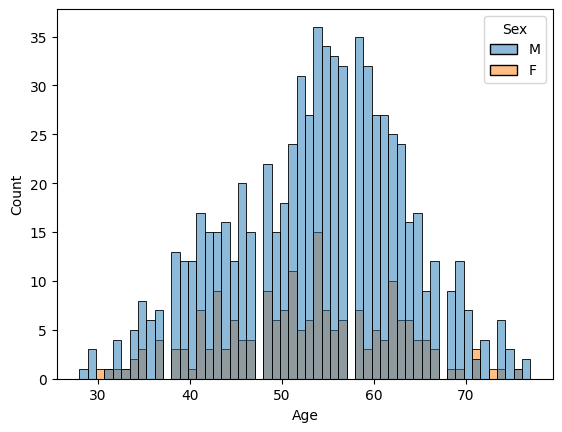

In [19]:
sns.histplot(data = df, x="Age", binwidth=0.9, hue="Sex")

изучим зависимость частоту сердечных заболиваний от возраста  

<Axes: xlabel='Age', ylabel='Count'>

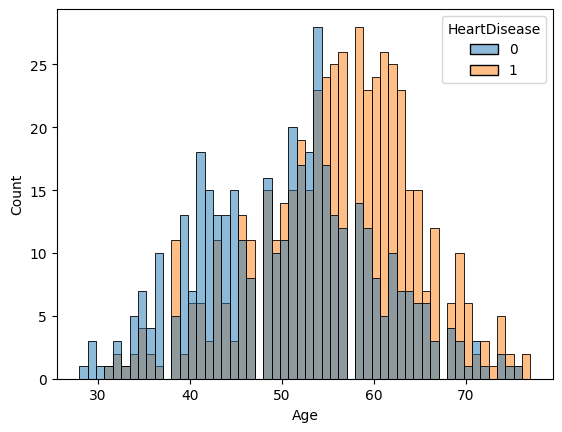

In [20]:
sns.histplot(data = df, x = 'Age', binwidth = 0.9, hue = "HeartDisease")

изучим процент заболевших для различного возраста.  

Применим МНК для построения линии тренда. Используем многочлен второй степени.

In [99]:
age_stats = df.groupby('Age')['HeartDisease'].agg(['count', 'sum']).reset_index()
age_stats['percentage'] = (age_stats['sum'] / age_stats['count']) * 100
A = np.column_stack([age_stats["Age"]**2, age_stats["Age"], np.ones_like(age_stats["Age"])])
b = np.array(age_stats['percentage'])
x_MGK =np.linalg.inv(A.T @ A) @ A.T @ b

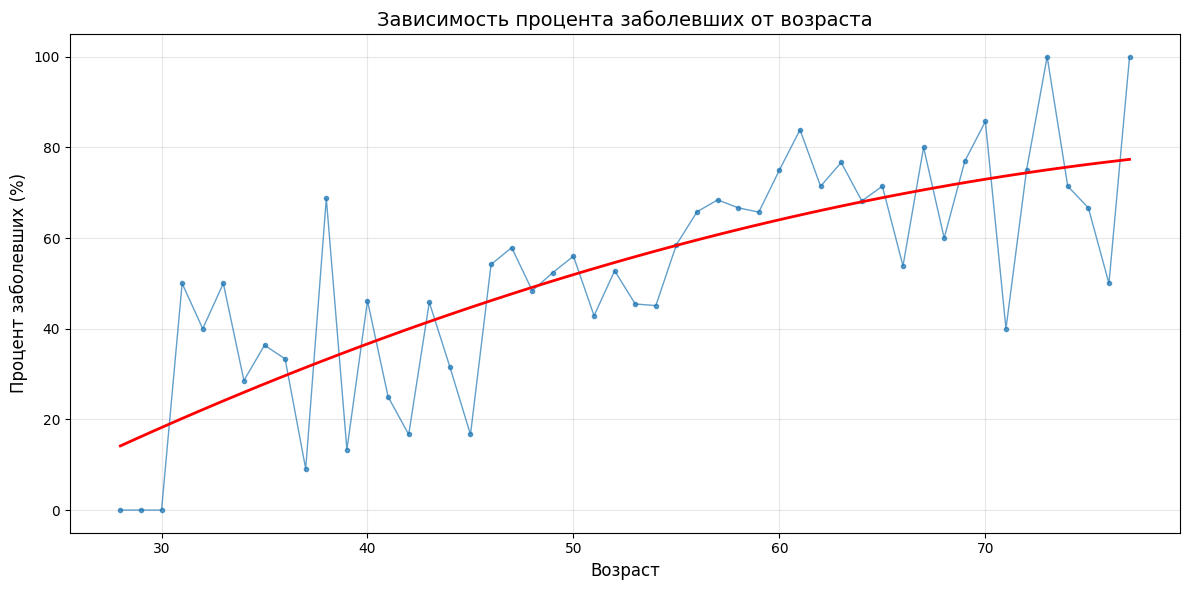

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(age_stats['Age'], age_stats['percentage'],
         marker='o', linestyle='-', linewidth=1, markersize=3, alpha=0.7)
def f(x):
   return x_MGK[0]*x**2 + x_MGK[1]*x + x_MGK[2]

x_range = np.linspace(min(age_stats['Age']), max(age_stats['Age']), 100)
y_values = f(x_range)

plt.plot(x_range, y_values, 'r-', linewidth=2, label='y = f(x)')


plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Процент заболевших (%)', fontsize=12)
plt.title('Зависимость процента заболевших от возраста', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

делаем проверку данных на соответствие нормальному распределению  

In [ ]:
g = sns.FacetGrid(df, col="HeartDisease", height=6, aspect=1.2, hue = "Sex")
g.map(sns.histplot, "Age", binwidth=0.9, kde=True)
g.set_titles(col_template="Heart Disease = {col_name}")
g.add_legend()
plt.show()

график зависимости наличия заболевания от пола.  

In [ ]:
df['HeartDisease_Label'] = df['HeartDisease'].map({0: 'No Disease', 1: 'Disease'})

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="HeartDisease_Label", binwidth=0.1, hue="Sex", shrink=0.8)
plt.xlabel("")
plt.ylabel('Count')
plt.legend(title='Sex', labels=['Male', 'Female'])
plt.tight_layout()
plt.show()
df = df.drop('HeartDisease_Label', axis = 1)

выведем всех людей с сердечными заболиваеями сгруппировав по полу.  
как видим, количество мужчин с сердечными заболеванием больше, чем количество женщин.  

In [ ]:
sns.histplot(data = df[df["HeartDisease"] == 1], x = "Age", binwidth = 0.7, hue = "Sex")

добавить график, ораньжевый столбец делить на синий. где ноль - не выводить.  

In [ ]:
heart_disease_data = df[df["HeartDisease"] == 1]
age_gender_counts = heart_disease_data.groupby(['Age', 'Sex']).size().unstack(fill_value=0)

ratios = []
ages_with_ratio = []
for age in age_gender_counts.index:
    if 'F' in age_gender_counts.columns and 'M' in age_gender_counts.columns:
        female_count = age_gender_counts.loc[age, 'F']
        male_count = age_gender_counts.loc[age, 'M']

        if female_count > 0:
            ratio = male_count / female_count
            ratios.append(ratio)
            ages_with_ratio.append(age)
    elif 'Female' in age_gender_counts.columns and 'Male' in age_gender_counts.columns:
        female_count = age_gender_counts.loc[age, 'Female']
        male_count = age_gender_counts.loc[age, 'Male']

        if female_count > 0:
            ratio = male_count / female_count
            ratios.append(ratio)
            ages_with_ratio.append(age)

plt.figure(figsize=(14, 6))
if len(ages_with_ratio) > 0:
    bars = plt.bar(ages_with_ratio, ratios, color='orange', alpha=0.7, width=0.7)
    plt.xlabel('Возраст')
    plt.ylabel('Соотношение (Мужчины/Женщины)')
    plt.title('Соотношение количества заболеваний мужчин к женщинам по возрастам')
    plt.grid(axis='y', alpha=0.3)

    for i, (age, ratio) in enumerate(zip(ages_with_ratio, ratios)):
        if ratio > 0:
            plt.text(age, ratio + 0.05, f'{ratio:.1f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.legend()
else:
    plt.text(0.5, 0.5, 'Нет данных для расчета соотношений по возрастам',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Соотношение количества заболеваний мужчин к женщинам по возрастам')

plt.tight_layout()
plt.show()

total_male = heart_disease_data[heart_disease_data['Sex'].isin(['M', 'Male'])].shape[0]
total_female = heart_disease_data[heart_disease_data['Sex'].isin(['F', 'Female'])].shape[0]

print(f"Общее количество мужчин с заболеваниями: {total_male}")
print(f"Общее количество женщин с заболеваниями: {total_female}")
if total_female > 0:
    total_ratio = total_male / total_female
    print(f"Общее соотношение (М/Ж): {total_ratio:.2f}")

Теперь совершенно очевидно, что мужчин на порядок больше в датасете.

посмотрим какие типы боли наиболее распространнены у мужчин и женщин.  

In [ ]:
sns.histplot(data = df, x = "Sex", binwidth = 0.2, hue = "ChestPainType", multiple = "stack")

переделать, чтобы наличие заболевания было нормально подписано.  


выведем какой тип боли встречается у больных и здоровых.  

In [ ]:
df['HeartDisease_Label'] = df['HeartDisease'].map({0: 'No Disease', 1: 'Disease'})

plt.figure(figsize=(10, 5))
ax = sns.histplot(data=df, x="HeartDisease_Label", binwidth=0.5,
                 hue="ChestPainType", multiple="stack")
plt.xlabel('Heart Disease Status')
plt.ylabel('Count')
plt.title('Distribution of Chest Pain Types by Disease Status')
plt.tight_layout()
plt.show()

df = df.drop('HeartDisease_Label', axis=1)

выведем матрицу кореляции числовых переменных.  

In [ ]:
figure_size = (6, 6)
frontsize_annotation = 10
fig, ax = plt.subplots(figsize = figure_size)
plt.title("Correlation martix")
heatmap = sns.heatmap(df.select_dtypes(include = ["int64", "float64"]).corr(),
                   annot=True,
                   square=True,
                   fmt='.1%',
                   cmap='GnBu',
                   cbar=False,
                   annot_kws={'size':str(frontsize_annotation)},
                   linewidth=0.1
                  )

plt.show()

# **Начинаем создание модели**

создаём список из имён параметров которые являются типом "object".  

In [ ]:
object_col = df.select_dtypes(include = "object").columns.to_list()

разбиваем параметры типа "object" по значениям, которые принимает переменная.   

In [ ]:
df_non_tree = pd.get_dummies(df, columns=object_col,drop_first=False)
df_non_tree.head()

переводим True и False в 1 и 0.  
сохраняем целевую переменную в y.  
в X оставляем остальные переменные.  

In [ ]:
y = df_non_tree["HeartDisease"].values
df_non_tree.drop("HeartDisease",axis=1,inplace=True)
df_non_tree=pd.concat([df_non_tree,df["HeartDisease"]],axis=1)
boolean_col = df_non_tree.select_dtypes(include = "boolean").columns.to_list()
df_non_tree[boolean_col] = df_non_tree[boolean_col].astype("int64")
X = df_non_tree.drop("HeartDisease",axis=1)
df_non_tree.head()

разбаваем дата сет поровну на тренировочный и тестовый набор данных.  


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

импортируем линейную регресию и среднюю кравдратичную ошибку из sklearn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

обучаем модель на тренировочных данных.  
проводим тестирование на тестовых.  

In [ ]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_predicted = model_linear.predict(X_test)

посмотрим на значение ошибок модели.  

In [ ]:
print("Score ",model_linear.score(X,y))
print("Mse ", mse(y_predicted,y_test))
print("Rmse ", np.sqrt(mse(y_predicted,y_test)))

выведим список предсказаний модели.  

округлим предсказанные значения выше 0.5 к 1.  
ниже к 0.  

In [ ]:
for i in range(len(y_predicted)):
  if y_predicted[i] >= 0.5:
    y_predicted[i]=int(1)
  else:
    y_predicted[i] = int(0)
y_predicted = y_predicted.astype("int64")

выведем коэфиценты модели.  


In [ ]:
model_linear.coef_
np.set_printoptions(suppress=True)
for i in range(model_linear.n_features_in_ - 1):
    print(f'{model_linear.feature_names_in_[i]} - { model_linear.coef_[i]}')

используем логистискую регресию.  
обучаем её на тренировачных данных.  


In [ ]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression(tol = 1e-100, max_iter=100000)
model_logistic.fit(X_train, y_train)
y_predicted_log = model_logistic.predict(X_test)

выводим значения ошибок модели

In [ ]:
print("Score ",model_logistic.score(X,y))
print("Mse ", mse(y_test, model_logistic.predict(X_test)))

выводим коэфиценты логистической регресии.  

In [ ]:
for i in range(model_logistic.n_features_in_ - 1):
    print(f'{model_logistic.feature_names_in_[i]} - {model_logistic.coef_[0][i]}')

# **Применим различные метрики к полученным результатам.**

Метрика accuracy.  

In [ ]:
acc = 0
for i in range(len(y_predicted)):
  if y_predicted[i] == y_test[i]:
    acc+=1
print(acc/(len(y_predicted)))


In [ ]:
model_logistic.predict(X_test)
acc_1 = 0
for i in range(len(model_logistic.predict(X_test))):
  if model_logistic.predict(X_test)[i] == y_test[i]:
    acc_1+=1
print(acc_1/(len(model_logistic.predict(X_test))))

Accuracy = Количество верных предсказаний / Общее количество примеров  
Видим, что обе модели в >80% случиях верно предсказывают результат.   

Метрика Sensitivity.  

In [ ]:
true_positive = 0
false_negative = 0
sensitivity = 0
for i in range(len(y_predicted)):
    if y_test[i] == 1:
        if y_predicted[i] == 1:
            true_positive += 1
        else:
            false_negative += 1
sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

print(f"Sensitivity: {sensitivity:.4f}")
print(f"True Positive: {true_positive}")
print(f"False Negative: {false_negative}")

In [ ]:
y_pred = model_logistic.predict(X_test)
true_positive = 0
false_negative = 0
sensitivity = 0
for i in range(len(y_pred)):
    if y_test[i] == 1:
        if y_pred[i] == 1:
            true_positive += 1
        else:
            false_negative += 1
sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

print(f"Sensitivity: {sensitivity:.4f}")
print(f"True Positive: {true_positive}")
print(f"False Negative: {false_negative}")

Sensitivity = Количество правильно обнаруженных больных / Количество реально больных людей  
Эта метрика показывает: какую долю действительно больных людей модель смогла правильно идентифицировать.  
в >84% случаях модели найдут у больного человека заболевание.    

Метрика Precision.  

In [ ]:
true_positive = 0
false_positive = 0
precision = 0
for i in range(len(y_predicted)):
    if y_predicted[i] == 1:
        if y_test[i] == 1:
            true_positive += 1
        else:
            false_positive += 1
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")

In [ ]:
y_pred = model_logistic.predict(X_test)
true_positive = 0
false_positive = 0
precision = 0
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        if y_test[i] == 1:
            true_positive += 1
        else:
            false_positive += 1
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")

Precision = Количество правильно обнаруженных больных / Количество людей, которых модель назвала больными  
Эта метрика показывает: Долю действительно больных среди тех, кого модель назвала больными.  
в >83% модель правильно определяет людей с заболеванием.  

# **Итог**
Провёл анализ датасета.
Вывел графики по различным параметрам.
В датасете преобладает информация о мужском поле.
Реализовал линейную и логистическую регресии.
Провёл тесты на трёх метриках: Precision, Sensitivity, Accuracy.
Во всёх тестах результаты около 85%.  